# Analizando datos de Enfermedades Transmitidas por Vector (Dengue) en México para los años 2021 y 2022

### Importando librerías

In [20]:
import sqlite3
import pandas as pd
import numpy as np
from unidecode import unidecode
import os
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')
import datetime as dt

### Creando conexión a la BD

In [21]:
# Se crea la conexión a la BD
connection = sqlite3.connect("dengue.db")

# Comprueba que la base de datos se ha creado correctamente
print (connection.total_changes)

# S crea el cursor que permite enviar instrucciones en SQL
cursor = connection.cursor()

0


Probemos la conexión ejecutando una consulta que nos regrese el número de registros que tiene la tabla:

In [22]:
cursor.execute("SELECT count(*) FROM dengue_301221")
rows = cursor.fetchall()

print(rows)

[(35413,)]


### Preprocesamiento de datos

Dado que la BD cuenta con una sola tabla, no es un modelo relacional. Por lo tanto se han creado diccionarios para cargar los diferentes catálogos de donde toma valores esta tabla.

In [23]:
# Nombre del archivo Excel
excel_file = "diccionario_datos\Catálogos_Dengue.xlsx"

# Cargar el archivo Excel
excel_data = pd.ExcelFile(excel_file)

# Obtener el nombre de todas las hojas en el archivo Excel
sheet_names = excel_data.sheet_names

# Iterar sobre cada hoja y guardarla como archivo CSV
for sheet_name in sheet_names:
    # Leer los datos de la hoja actual
    df = excel_data.parse(sheet_name)
    
    # Quitar los acentos y remplazar los espacios en los nombres...
    sheet_name = '_'.join(sheet_name.split()).upper()
    sheet_name = unidecode(sheet_name)

    # Crear el nombre del archivo CSV (usando el nombre de la hoja)
    csv_file = f'diccionario_datos\Catálogos\{sheet_name}.csv'
    
    # Guardar los datos en el archivo CSV
    df.to_csv(csv_file, index=False)
    
    print(f'Guardando {csv_file}')

# Cerrar el archivo Excel
excel_data.close()

# Luego se cargan a un diccionario de Python que contendrá todos los catálogos...
# Ruta de la carpeta que contiene los Catálogos... CSV
carpeta = 'diccionario_datos\Catálogos'

# Diccionario para almacenar los diccionarios de cada archivo CSV
diccionarios = {}

# Iterar sobre cada archivo en la carpeta
for archivo in os.listdir(carpeta):
    if archivo.endswith('.csv'):
        # Crear la ruta completa al archivo
        ruta_completa = os.path.join(carpeta, archivo)
        
        # Cargar el archivo CSV en un DataFrame de pandas
        df = pd.read_csv(ruta_completa)
        
        # Crear un diccionario con el nombre del archivo como clave
        # y la primera columna como clave y la segunda columna como valor
        diccionario = dict(zip(df.iloc[:, 0], df.iloc[:, 1]))
        
        # Agregar el diccionario al diccionario principal, y de paso quitarle la extensión al nombre (.csv)...
        diccionarios[archivo[:-4]] = diccionario
        # Eliminar espacios detectados a la derecha o izquierda de los valores en el diccionario...
        diccionarios[archivo[:-4]] = {clave: valor.strip() for clave, valor in diccionarios[archivo[:-4]].items()}

# Ver los diccionarios...
diccionarios.keys()

# Ahora, diccionarios contiene un diccionario para cada archivo CSV con la primera columna como clave y la segunda columna como valor...

Guardando diccionario_datos\Catálogos\CATALOGO_ESTATUS_CASO.csv
Guardando diccionario_datos\Catálogos\CATALOGO_RESULTADO_PCR.csv
Guardando diccionario_datos\Catálogos\CATALOGO_DICTAMEN.csv
Guardando diccionario_datos\Catálogos\CATALOGO_INSTITUCION.csv
Guardando diccionario_datos\Catálogos\CATALOGO_TIPO_PACIENTE.csv
Guardando diccionario_datos\Catálogos\CATALOGO_MUNICIPIO.csv
Guardando diccionario_datos\Catálogos\CATALOGO_ENTIDAD.csv
Guardando diccionario_datos\Catálogos\CATALOGO_SI_NO.csv
Guardando diccionario_datos\Catálogos\CATALOGO_SEXO.csv


dict_keys(['CATALOGO_DICTAMEN', 'CATALOGO_ENTIDAD', 'CATALOGO_ESTATUS_CASO', 'CATALOGO_INSTITUCION', 'CATALOGO_MUNICIPIO', 'CATALOGO_RESULTADO_PCR', 'CATALOGO_SEXO', 'CATALOGO_SI_NO', 'CATALOGO_TIPO_PACIENTE'])

### Usando SQL Queries vs. Manipulando Dataframes 

Se han utiliazado dos enfoques: 

1) Usando SQL queries para cargar en Dataframes las tablas completas de la BD y trabajar sobre los Dataframes.
   
2) Usando SQL queries para realizar diversas consultas a la BD y guardar el resultado final en un Dataframe.

Esto con el fin de practicar el uso de SQL Queries en Python, así como también poder observar las diferencias entre ambos enfoques.

Aquí se cargan las tablas para utilizar primer enfoque:

In [24]:
# Tablas de la DB: "dengue_301221" y "dengue_201222"...

# Seleccionar las variables a utilizar...
variables = ["SEXO", "EDAD_ANOS", "ENTIDAD_RES", "MUNICIPIO_RES", "FECHA_SIGN_SINTOMAS",
            "TIPO_PACIENTE", "INDIGENA", "HEMORRAGICOS", "DIABETES", "HIPERTENSION", "ENFERMEDAD_ULC_PEPTICA",
            "ENFERMEDAD_RENAL", "INMUNOSUPR", "CIRROSIS_HEPATICA", "EMBARAZO", "DEFUNCION", "DICTAMEN",
            "RESULTADO_PCR", "ESTATUS_CASO"]
columnas_select = ', '.join(variables)
# Creando la Querry de forma segura...
query_21 = f"SELECT {columnas_select} FROM dengue_301221"
query_22 = f"SELECT {columnas_select} FROM dengue_201222"

df_dengue_2021 = pd.read_sql_query(query_21, connection, parse_dates= ["FECHA_SIGN_SINTOMAS"]) # Parser las fechas de una vez...
df_dengue_2022 = pd.read_sql_query(query_22, connection, parse_dates= ["FECHA_SIGN_SINTOMAS"])

# Mapear los catálogos para trabajar de forma cómoda con los datos...
df_dengue_2021["SEXO"] = df_dengue_2021["SEXO"].map(diccionarios["CATALOGO_SEXO"])
df_dengue_2021["ENTIDAD_RES"] = df_dengue_2021["ENTIDAD_RES"].map(diccionarios["CATALOGO_ENTIDAD"])
df_dengue_2021["MUNICIPIO_RES"] = df_dengue_2021["MUNICIPIO_RES"].map(diccionarios["CATALOGO_MUNICIPIO"])
df_dengue_2021["TIPO_PACIENTE"] = df_dengue_2021["TIPO_PACIENTE"].map(diccionarios["CATALOGO_TIPO_PACIENTE"])
df_dengue_2021["INDIGENA"] = df_dengue_2021["INDIGENA"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2021["DIABETES"] = df_dengue_2021["DIABETES"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2021["HIPERTENSION"] = df_dengue_2021["HIPERTENSION"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2021["ENFERMEDAD_ULC_PEPTICA"] = df_dengue_2021["ENFERMEDAD_ULC_PEPTICA"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2021["ENFERMEDAD_RENAL"] = df_dengue_2021["ENFERMEDAD_RENAL"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2021["INMUNOSUPR"] = df_dengue_2021["INMUNOSUPR"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2021["CIRROSIS_HEPATICA"] = df_dengue_2021["CIRROSIS_HEPATICA"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2021["EMBARAZO"] = df_dengue_2021["EMBARAZO"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2021["HEMORRAGICOS"] = df_dengue_2021["HEMORRAGICOS"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2021["DEFUNCION"] = df_dengue_2021["DEFUNCION"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2021["DICTAMEN"] = df_dengue_2021["DICTAMEN"].map(diccionarios["CATALOGO_DICTAMEN"])
df_dengue_2021["RESULTADO_PCR"] = df_dengue_2021["RESULTADO_PCR"].map(diccionarios["CATALOGO_RESULTADO_PCR"])
df_dengue_2021["ESTATUS_CASO"] = df_dengue_2021["ESTATUS_CASO"].map(diccionarios["CATALOGO_ESTATUS_CASO"])
df_dengue_2021["FECHA_SIGN_SINTOMAS"].sort_values()
df_dengue_2021["MESES"] = df_dengue_2021["FECHA_SIGN_SINTOMAS"].dt.month

df_dengue_2022["SEXO"] = df_dengue_2022["SEXO"].map(diccionarios["CATALOGO_SEXO"])
df_dengue_2022["ENTIDAD_RES"] = df_dengue_2022["ENTIDAD_RES"].map(diccionarios["CATALOGO_ENTIDAD"])
df_dengue_2022["MUNICIPIO_RES"] = df_dengue_2022["MUNICIPIO_RES"].map(diccionarios["CATALOGO_MUNICIPIO"])
df_dengue_2022["TIPO_PACIENTE"] = df_dengue_2022["TIPO_PACIENTE"].map(diccionarios["CATALOGO_TIPO_PACIENTE"])
df_dengue_2022["INDIGENA"] = df_dengue_2022["INDIGENA"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2022["DIABETES"] = df_dengue_2022["DIABETES"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2022["HIPERTENSION"] = df_dengue_2022["HIPERTENSION"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2022["ENFERMEDAD_ULC_PEPTICA"] = df_dengue_2022["ENFERMEDAD_ULC_PEPTICA"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2022["ENFERMEDAD_RENAL"] = df_dengue_2022["ENFERMEDAD_RENAL"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2022["INMUNOSUPR"] = df_dengue_2022["INMUNOSUPR"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2022["CIRROSIS_HEPATICA"] = df_dengue_2022["CIRROSIS_HEPATICA"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2022["EMBARAZO"] = df_dengue_2022["EMBARAZO"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2022["HEMORRAGICOS"] = df_dengue_2022["HEMORRAGICOS"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2022["DEFUNCION"] = df_dengue_2022["DEFUNCION"].map(diccionarios["CATALOGO_SI_NO"])
df_dengue_2022["DICTAMEN"] = df_dengue_2022["DICTAMEN"].map(diccionarios["CATALOGO_DICTAMEN"])
df_dengue_2022["RESULTADO_PCR"] = df_dengue_2022["RESULTADO_PCR"].map(diccionarios["CATALOGO_RESULTADO_PCR"])
df_dengue_2022["ESTATUS_CASO"] = df_dengue_2022["ESTATUS_CASO"].map(diccionarios["CATALOGO_ESTATUS_CASO"])
df_dengue_2022["FECHA_SIGN_SINTOMAS"].sort_values()
df_dengue_2022["MESES"] = df_dengue_2022["FECHA_SIGN_SINTOMAS"].dt.month

print(f"Dengue 2021: {df_dengue_2021.shape[0]} casos. Dengue 2022: {df_dengue_2022.shape[0]} casos.") 
print("Dengue 2022:")
df_dengue_2022.head()

Dengue 2021: 35413 casos. Dengue 2022: 57730 casos.
Dengue 2022:


,SEXO,EDAD_ANOS,ENTIDAD_RES,MUNICIPIO_RES,FECHA_SIGN_SINTOMAS,TIPO_PACIENTE,INDIGENA,HEMORRAGICOS,DIABETES,HIPERTENSION,ENFERMEDAD_ULC_PEPTICA,ENFERMEDAD_RENAL,INMUNOSUPR,CIRROSIS_HEPATICA,EMBARAZO,DEFUNCION,DICTAMEN,RESULTADO_PCR,ESTATUS_CASO,MESES
0,MUJER,47,NAYARIT,JEREZ,2022-01-26,AMBULATORIO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO APLICA,SIN SEROTIPO AISLADO,DESCARTADO,1
1,MUJER,34,SINALOA,HUANUSCO,2022-01-29,AMBULATORIO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO APLICA,SIN SEROTIPO AISLADO,DESCARTADO,1
2,HOMBRE,50,QUINTANA ROO,APULCO,2022-01-29,AMBULATORIO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO APLICA,SIN SEROTIPO AISLADO,DESCARTADO,1
3,HOMBRE,23,VERACRUZ DE IGNACIO DE LA LLAVE,VERACRUZ,2022-01-28,HOSPITALIZADO,NO,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO APLICA,SIN SEROTIPO AISLADO,DESCARTADO,1
4,HOMBRE,23,GUERRERO,MIGUEL AUZA,2022-04-10,AMBULATORIO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO APLICA,SIN SEROTIPO AISLADO,PROBABLE,4


### Realizando algunas consultas a nivel nacional

##### Número de casos confirmados en todo México durante los años 2021 y 2022

Aquí un ejemplo de como sería utilizando el enfoque #2:

In [25]:
# Se define el query
query_confirmados_nacional_2021 = "SELECT * \
                                    FROM dengue_301221 \
                                    WHERE Dictamen = 1 \
                                    OR Dictamen = 2" 

# Se crea el DataFrame ejecutando el query
df_confirmados_mexico_2021 = pd.read_sql_query(query_confirmados_nacional_2021
                                            , connection \
                                            , parse_dates= ["FECHA_SIGN_SINTOMAS"])

# Se define el query  
query_confirmados_nacional_2022 = "SELECT * \
                                    FROM dengue_201222 \
                                    WHERE Dictamen = 1 \
                                    OR Dictamen = 2" 

# Se crea el DataFrame ejecutando el query
df_confirmados_mexico_2022 = pd.read_sql_query(query_confirmados_nacional_2022
                                            , connection \
                                            , parse_dates= ["FECHA_SIGN_SINTOMAS"])

    
# Se concatenan los DataFrames   
df_confirmados_mexico_2021_2022 = pd.concat([df_confirmados_mexico_2021, df_confirmados_mexico_2022], ignore_index=True)

# Se crea una columna con el día, mes y año de la fecha de signos y síntomas
df_confirmados_mexico_2021_2022['DIA'] = df_confirmados_mexico_2021_2022['FECHA_SIGN_SINTOMAS'].dt.day
df_confirmados_mexico_2021_2022['MES'] = df_confirmados_mexico_2021_2022['FECHA_SIGN_SINTOMAS'].dt.month
df_confirmados_mexico_2021_2022['AÑO'] = df_confirmados_mexico_2021_2022['FECHA_SIGN_SINTOMAS'].dt.year
    
    

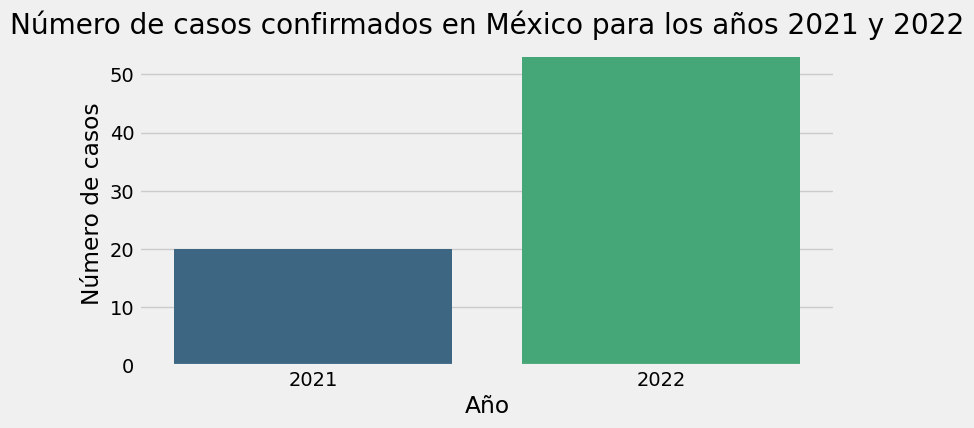

In [26]:
plt.figure(figsize=(8, 4))    

ax = sns.countplot(data = df_confirmados_mexico_2021_2022, x = 'AÑO', palette="viridis")

ax.set(title = "Número de casos confirmados en México para los años 2021 y 2022", xlabel = "Año", ylabel = "Número de casos")

plt.show()

##### Número de casos confirmados por Entidad

In [27]:
# Se mapean claves de ENTIDAD_RES con el catálogo CATALOGO_ENTIDAD
df_confirmados_mexico_2021['ENTIDAD_RES_NOMBRE'] = df_confirmados_mexico_2021['ENTIDAD_RES'].map(diccionarios['CATALOGO_ENTIDAD'])
df_confirmados_mexico_2022['ENTIDAD_RES_NOMBRE'] = df_confirmados_mexico_2022['ENTIDAD_RES'].map(diccionarios['CATALOGO_ENTIDAD'])

Podemos ver que en 2021 hubo en realidad pocos casos confirmados, sólo en 8 estados de la república:

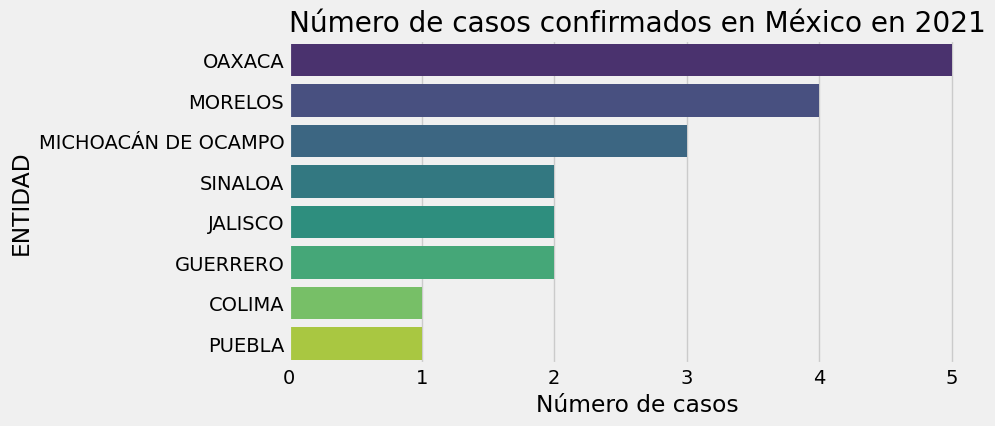

In [28]:
plt.figure(figsize=(8, 4))

ax = sns.countplot(data = df_confirmados_mexico_2021, 
                   y = 'ENTIDAD_RES_NOMBRE', 
                   order = df_confirmados_mexico_2021['ENTIDAD_RES_NOMBRE'].value_counts().index,
                   palette = "viridis")

ax.set(title = "Número de casos confirmados en México en 2021", ylabel = "ENTIDAD", xlabel = "Número de casos")

plt.show()

Sin embargo, para 2022 los casos confirmados aumentaron considerablemente, poniendo a **Sonora** en el primer lugar con 14 casos.

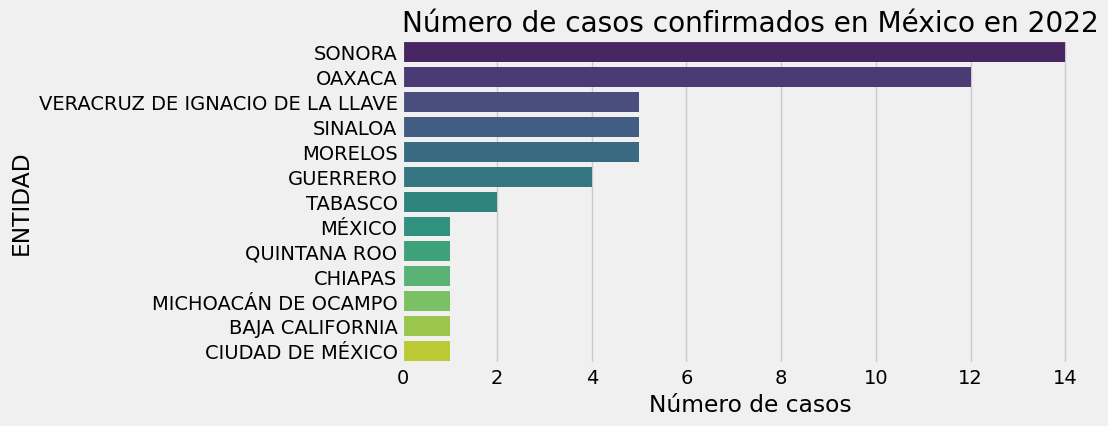

In [29]:
plt.figure(figsize=(8, 4))

ax = sns.countplot(data = df_confirmados_mexico_2022, 
                   y = 'ENTIDAD_RES_NOMBRE', 
                   order = df_confirmados_mexico_2022['ENTIDAD_RES_NOMBRE'].value_counts().index,
                   palette = "viridis")

ax.set(title = "Número de casos confirmados en México en 2022", ylabel = "ENTIDAD", xlabel = "Número de casos")

plt.show()

##### Número de casos confirmados, fallecidos mensual y anual

In [30]:
muertes_dengue_2021 = df_dengue_2021[(df_dengue_2021["ESTATUS_CASO"] == "CONFIRMADO") & (df_dengue_2021["DEFUNCION"] == "SI")]
muertes_dengue_2021 = muertes_dengue_2021[["MESES"]].groupby(by =[muertes_dengue_2021["MESES"]]).count()
muertes_dengue_2021.columns = ["CASOS"]
muertes_dengue_2021 = muertes_dengue_2021.reset_index()

muertes_dengue_2022 = df_dengue_2022[(df_dengue_2022["ESTATUS_CASO"] == "CONFIRMADO") & (df_dengue_2022["DEFUNCION"] == "SI")]
muertes_dengue_2022 = muertes_dengue_2022[["MESES"]].groupby(by =[muertes_dengue_2022["MESES"]]).count()
muertes_dengue_2022.columns = ["CASOS"]
muertes_dengue_2022 = muertes_dengue_2022.reset_index()

# muertes_dengue_2021

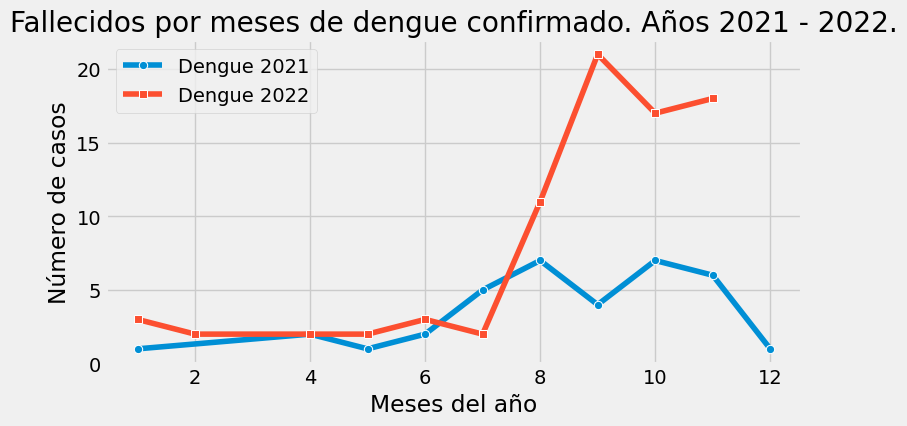

In [31]:
plt.figure(figsize=(8, 4))

ax = sns.lineplot(data = muertes_dengue_2021, x ='MESES' , y = "CASOS", label = "Dengue 2021", marker='o')
ax = sns.lineplot(data = muertes_dengue_2022, x ='MESES' , y = "CASOS", label = "Dengue 2022", marker='s')
ax.set(title = "Fallecidos por meses de dengue confirmado. Años 2021 - 2022.", xlabel = "Meses del año", ylabel = "Número de casos")

plt.legend()

# Mostrar el gráfico
plt.show()

Acá se pudo observar como en ambos años ocurre un alza de los casos de fallecidos por dengue en México hacia los últimos meses del año.
Notándose además que estas cifras fueron mayores en el 2022.

##### Casos de Dengue Hemorrágico confirmado por meses. Años 2021 - 2022.

In [32]:
dengue_2021_h = df_dengue_2021[(df_dengue_2021["ESTATUS_CASO"] == "CONFIRMADO") & (df_dengue_2021["HEMORRAGICOS"] == "SI")]
dengue_2021_h = dengue_2021_h[["MESES"]].groupby(by =[dengue_2021_h["MESES"]]).count()
dengue_2021_h.columns = ["CASOS"]
dengue_2021_h = dengue_2021_h.reset_index()

dengue_2022_h = df_dengue_2022[(df_dengue_2022["ESTATUS_CASO"] == "CONFIRMADO") & (df_dengue_2022["HEMORRAGICOS"] == "SI")]
dengue_2022_h = dengue_2022_h[["MESES"]].groupby(by =[dengue_2022_h["MESES"]]).count()
dengue_2022_h.columns = ["CASOS"]
dengue_2022_h = dengue_2022_h.reset_index()

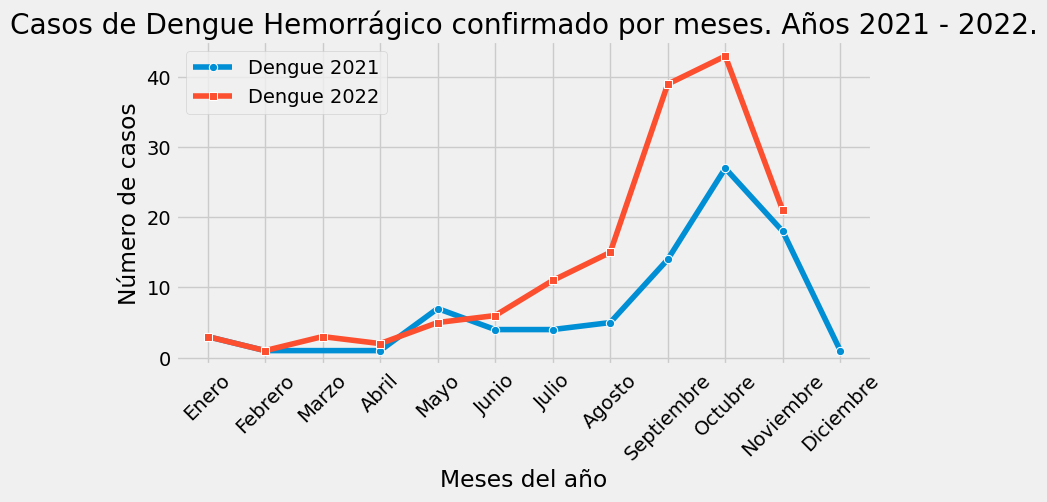

In [33]:
plt.figure(figsize=(8, 4))

ax = sns.lineplot(data = dengue_2021_h, x ='MESES' , y = "CASOS", label = "Dengue 2021", marker='o')
ax = sns.lineplot(data = dengue_2022_h, x ='MESES' , y = "CASOS", label = "Dengue 2022", marker='s')
ax.set(title = "Casos de Dengue Hemorrágico confirmado por meses. Años 2021 - 2022.",
       xticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
       xticklabels = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"],
       xlabel = "Meses del año", ylabel = "Número de casos")

plt.xticks(rotation=45)

plt.legend()

# Mostrar el gráfico
plt.show()

### Ahora algunas consultas a nivel municipal para el estado de **Sonora**

Primero, creamos una vista (para fines de aprendizaje y práctica) que contenga todos los registros donde la Entidad de Residencia sea **Sonora**:


In [34]:
# Revisa si la vista ya existe y la elimina
cursor.execute("DROP VIEW IF EXISTS vw_dengue_sonora_2021_2022")

rows = cursor.fetchall()
print(rows)

# Crea la vista
cursor.execute("CREATE VIEW vw_dengue_sonora_2021_2022 AS \
                SELECT * FROM dengue_301221 \
                WHERE ENTIDAD_RES = 26 \
                UNION \
                SELECT * FROM dengue_201222 \
                WHERE ENTIDAD_RES = 26")

rows = cursor.fetchall()
print(rows)



[]
[]


##### Número de casos confirmados en los municipios de Sonora en 2021 y 2022

Para este caso, vemos que en 2021 no se reportan casos confirmados en Sonora.

En 2022 hay 13 casos, sin embargo, es un poco extraño ya que estos registros en todas sus columnas asociadas a la Entidad pertenecen a Sonora, sin embargo, los Municipios no corresponden a los del estado de Sonora. 

In [35]:
df_dengue_sonora_municipal_2021_2022 = pd.read_sql_query("SELECT * \
                                                        FROM vw_dengue_sonora_2021_2022\
                                                        WHERE Dictamen = 1 \
                                                        OR Dictamen = 2" \
                                                    , connection
                                                    , parse_dates= ["FECHA_SIGN_SINTOMAS"])

df_dengue_sonora_municipal_2021_2022['AÑO'] = df_dengue_sonora_municipal_2021_2022['FECHA_SIGN_SINTOMAS'].dt.year
df_dengue_sonora_municipal_2021 = df_dengue_sonora_municipal_2021_2022[df_dengue_sonora_municipal_2021_2022['AÑO'] == 2021]
df_dengue_sonora_municipal_2022 = df_dengue_sonora_municipal_2021_2022[df_dengue_sonora_municipal_2021_2022['AÑO'] == 2022]

# Mapear claves de MUNICIPIO_RES con el catálogo CATALOGO_MUNICIPIO
df_dengue_sonora_municipal_2021['MUNICIPIO_RES_NOMBRE'] = df_dengue_sonora_municipal_2021['MUNICIPIO_RES'].map(diccionarios['CATALOGO_MUNICIPIO'])
df_dengue_sonora_municipal_2022['MUNICIPIO_RES_NOMBRE'] = df_dengue_sonora_municipal_2022['MUNICIPIO_RES'].map(diccionarios['CATALOGO_MUNICIPIO'])

df_dengue_sonora_municipal_2022



,FECHA_ACTUALIZACION,ID_REGISTRO,SEXO,EDAD_ANOS,ENTIDAD_RES,MUNICIPIO_RES,HABLA_LENGUA_INDIG,INDIGENA,ENTIDAD_UM_NOTIF,MUNICIPIO_UM_NOTIF,INSTITUCION_UM_NOTIF,FECHA_SIGN_SINTOMAS,TIPO_PACIENTE,HEMORRAGICOS,DIABETES,HIPERTENSION,ENFERMEDAD_ULC_PEPTICA,ENFERMEDAD_RENAL,INMUNOSUPR,CIRROSIS_HEPATICA,EMBARAZO,DEFUNCION,DICTAMEN,TOMA_MUESTRA,RESULTADO_PCR,ESTATUS_CASO,ENTIDAD_ASIG,MUNICIPIO_ASIG,AÑO,MUNICIPIO_RES_NOMBRE
0,2022-12-12,958539,2,66,26,3,2,2,26,42,4,2022-08-23,2,2,1,2,2,2,2,2,2,1,1,1,5,2,26,3,2022,ATOLINGA
1,2022-12-12,961820,2,66,26,42,2,2,26,42,4,2022-09-01,2,2,2,2,2,1,2,1,2,1,1,1,5,2,26,42,2022,SOMBRERETE
2,2022-12-12,963443,1,31,26,26,2,2,26,42,4,2022-09-05,2,2,2,2,2,2,2,2,2,1,1,1,2,2,26,26,2022,MAZAPIL
3,2022-12-12,967734,2,20,26,42,2,2,26,42,12,2022-09-17,2,2,2,2,2,2,2,2,2,1,1,2,5,2,26,42,2022,SOMBRERETE
4,2022-12-12,968398,2,26,26,42,2,2,26,42,12,2022-09-19,2,2,2,2,2,2,2,2,2,1,1,1,5,2,26,42,2022,SOMBRERETE
5,2022-12-12,968884,1,27,26,42,2,2,26,18,4,2022-09-19,2,2,2,2,2,2,2,2,1,1,1,1,2,2,26,42,2022,SOMBRERETE
6,2022-12-12,969626,1,13,26,42,2,2,26,42,12,2022-09-22,2,2,2,2,2,2,2,2,2,1,1,2,5,2,26,42,2022,SOMBRERETE
7,2022-12-12,970259,2,58,26,42,2,2,26,18,4,2022-09-24,2,2,2,1,2,2,2,2,2,1,1,1,5,2,26,42,2022,SOMBRERETE
8,2022-12-12,970597,1,44,26,3,2,2,26,3,12,2022-09-21,1,2,2,2,2,2,2,2,2,1,1,1,5,2,26,3,2022,ATOLINGA
9,2022-12-12,970874,1,7,26,42,2,2,26,30,12,2022-09-24,2,2,2,2,2,2,2,2,2,1,1,1,2,2,26,42,2022,SOMBRERETE


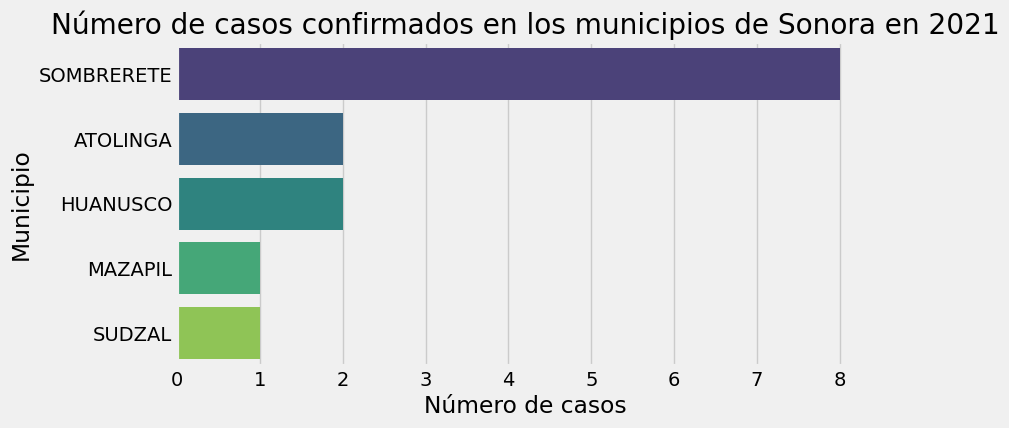

In [36]:
plt.figure(figsize=(8, 4))

ax = sns.countplot(data = df_dengue_sonora_municipal_2022, 
                   y = 'MUNICIPIO_RES_NOMBRE', 
                   order = df_dengue_sonora_municipal_2022['MUNICIPIO_RES_NOMBRE'].value_counts().index,
                   palette = "viridis")
ax.set(title = "Número de casos confirmados en los municipios de Sonora en 2021", ylabel = "Municipio", xlabel = "Número de casos")

plt.show()

##### Defunciones por cada enfermedad a nivel nacional

In [37]:
# Creemos un DataFrame nuevo con las columnas que necesitas
df_patologias = pd.DataFrame(columns=['Patologia', 'Confirmados', 'Defuncion'])
patologias = ['DIABETES', 'HIPERTENSION', 'ENFERMEDAD_ULC_PEPTICA', 'ENFERMEDAD_RENAL', 'INMUNOSUPR', 'CIRROSIS_HEPATICA']

# Iteramos sobre las patologías
for patologia in patologias:
    # Contamos la cantidad cuando la patología es igual a 'SI' y el estatus caso es 'CONFIRMADO'
    cantidad_confirmado = df_dengue_2021[(df_dengue_2021[patologia] == 'SI') & (df_dengue_2021['ESTATUS_CASO'] == 'CONFIRMADO') ].shape[0]
    # Contamos la cantidad cuando la patología es igual a 'SI' y la defunción es 'SI'
    cantidad_defuncion = df_dengue_2021[(df_dengue_2021[patologia] == 'SI') & (df_dengue_2021['DEFUNCION'] == 'SI')].shape[0]
    # Añadimos los resultados al nuevo DataFrame
    df_patologias = pd.concat([df_patologias, pd.DataFrame({'Patologia': [patologia], 'Confirmados': [cantidad_confirmado], 'Defuncion': [cantidad_defuncion]})], ignore_index=True)

df_patologias.sort_values(by= 'Confirmados', ascending=False, inplace=True)

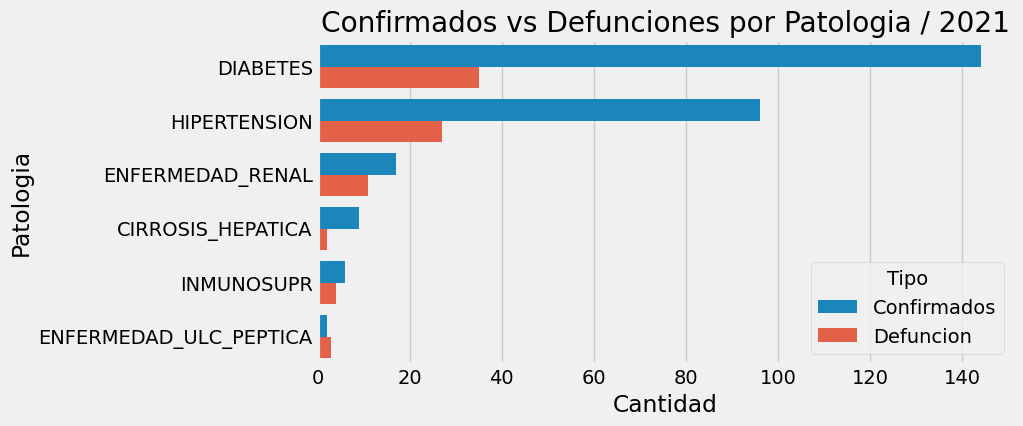

In [38]:
# Convertimos el DataFrame a formato largo
df_long = pd.melt(df_patologias, id_vars='Patologia', var_name='Tipo', value_name='Cantidad') 

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='Cantidad', y='Patologia', hue='Tipo', data=df_long)
ax.set(xlabel='Cantidad', ylabel='Patologia', title='Confirmados vs Defunciones por Patologia / 2021')
plt.show()

##### Defunciones de Indigenas por Estado 

In [39]:
# Crear un DataFrame de defunciones de indígenas
df_defunciones_indigenas = df_dengue_2021[(df_dengue_2021["ESTATUS_CASO"] == "CONFIRMADO") & (df_dengue_2021["INDIGENA"] == "SI")]

# Contar casos confirmados y defunciones por entidad
df_resultado = df_defunciones_indigenas.groupby("ENTIDAD_RES")["DEFUNCION"].value_counts().unstack().fillna(0)

# Renombrar las columnas para mayor claridad
df_resultado.columns = ["Confirmados", "Defunciones"]

# Reiniciar el índice para que 'ENTIDAD_RES' sea una columna
df_resultado.reset_index(inplace=True)
df_resultado.sort_values(by= 'Confirmados', ascending=False, inplace=True)

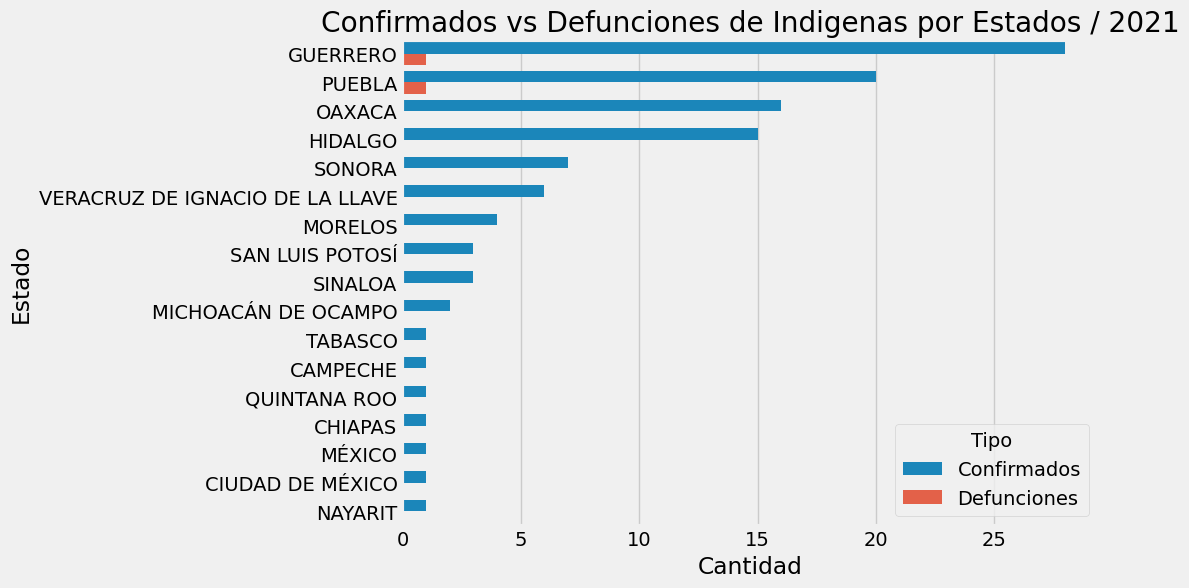

In [40]:
# Convertimos el DataFrame a formato largo
df_long = pd.melt(df_resultado, id_vars='ENTIDAD_RES', var_name='Tipo', value_name='Cantidad') 

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='Cantidad', y='ENTIDAD_RES', hue='Tipo', data=df_long)
ax.set(xlabel='Cantidad', ylabel='Estado', title='Confirmados vs Defunciones de Indigenas por Estados / 2021')
plt.show()

##### Defunciones de Embarazadas por Estado

In [41]:
df_defunciones_emabarazadas = df_dengue_2021[(df_dengue_2021["ESTATUS_CASO"] == "CONFIRMADO") & (df_dengue_2021["EMBARAZO"] == "SI")]
# Contar casos confirmados y defunciones por entidad
df_resultado = df_defunciones_emabarazadas.groupby("ENTIDAD_RES")["DEFUNCION"].value_counts().unstack().fillna(0)
# Renombrar las columnas para mayor claridad
df_resultado.columns = ["Confirmados", "Defunciones"]
# Reiniciar el índice para que 'ENTIDAD_RES' sea una columna
df_resultado.reset_index(inplace=True)
df_resultado.sort_values(by= 'Confirmados', ascending=False, inplace=True)

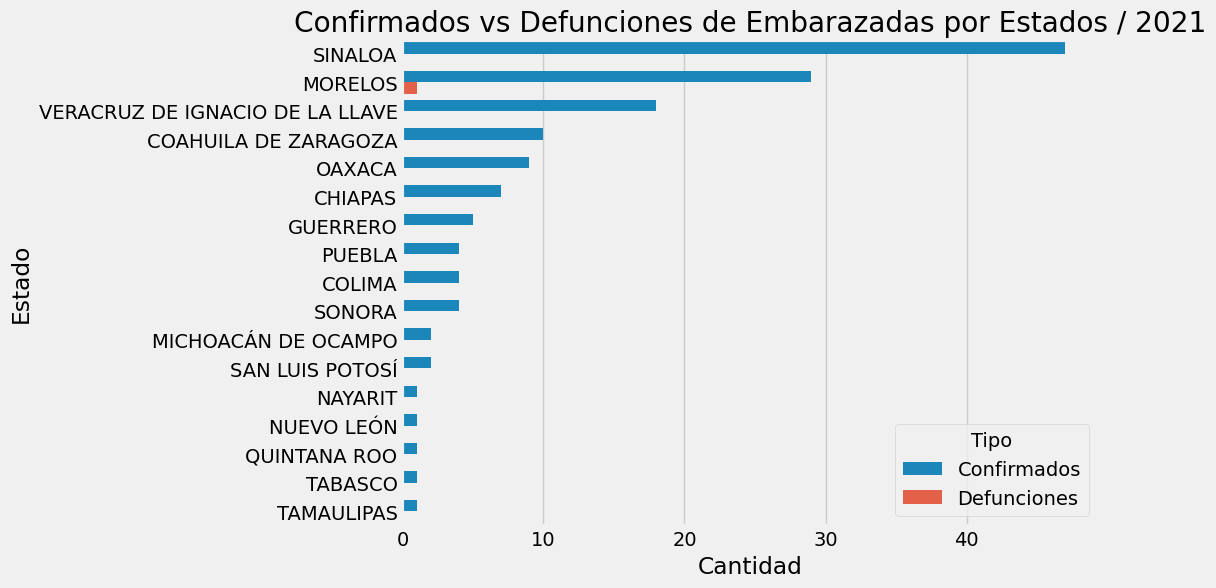

In [42]:
# Convertimos el DataFrame a formato largo
df_long = pd.melt(df_resultado, id_vars='ENTIDAD_RES', var_name='Tipo', value_name='Cantidad') 

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='Cantidad', y='ENTIDAD_RES', hue='Tipo', data=df_long)
ax.set(xlabel='Cantidad', ylabel='Estado', title='Confirmados vs Defunciones de Embarazadas por Estados / 2021')
plt.show()

##### Mapa Confirmados Dengue 2021

In [43]:
# Cuenta cuantos casos confiramdos hay en 2021
df_geo = df_dengue_2021[(df_dengue_2021["ESTATUS_CASO"] == "CONFIRMADO") ]
df_geo = df_geo.groupby('ENTIDAD_RES').size().reset_index(name='Casos')
df_geo.sort_values('ENTIDAD_RES', inplace=True)

In [44]:
estado_mapping = {
    'AGUASCALIENTES': 'Aguascalientes', 'BAJA CALIFORNIA': 'Baja California', 'BAJA CALIFORNIA SUR': 'Baja California Sur',
    'CAMPECHE': 'Campeche', 'COAHUILA DE ZARAGOZA': 'Coahuila', 'COLIMA': 'Colima', 'CHIAPAS': 'Chiapas', 'CHIHUAHUA': 'Chihuahua',
    'CIUDAD DE MÉXICO': 'Ciudad de México', 'DURANGO': 'Durango', 'GUANAJUATO': 'Guanajuato', 'GUERRERO': 'Guerrero',
    'HIDALGO': 'Hidalgo', 'JALISCO': 'Jalisco', 'MÉXICO': 'México', 'MICHOACÁN DE OCAMPO': 'Michoacán', 'MORELOS': 'Morelos',
    'NAYARIT': 'Nayarit', 'NUEVO LEÓN': 'Nuevo León', 'OAXACA': 'Oaxaca', 'PUEBLA': 'Puebla', 'QUERÉTARO': 'Querétaro',
    'QUINTANA ROO': 'Quintana Roo', 'SAN LUIS POTOSÍ': 'San Luis Potosí', 'SINALOA': 'Sinaloa', 'SONORA': 'Sonora',
    'TABASCO': 'Tabasco', 'TAMAULIPAS': 'Tamaulipas', 'TLAXCALA': 'Tlaxcala', 'VERACRUZ DE IGNACIO DE LA LLAVE': 'Veracruz', 
    'YUCATÁN': 'Yucatán', 'ZACATECAS': 'Zacatecas'
}

df_geo['Estado'] = df_geo['ENTIDAD_RES'].map(estado_mapping)

In [45]:
geojson_file_estados = 'https://raw.githubusercontent.com/Axel-Castro/GeoJson-Mex/main/Geojson_Mex/Estados_Mexico_WGS84.json'
gdf_estados = gpd.read_file(geojson_file_estados)

merged_estados = gdf_estados.join(df_geo.set_index('Estado'), on='name', how='left')

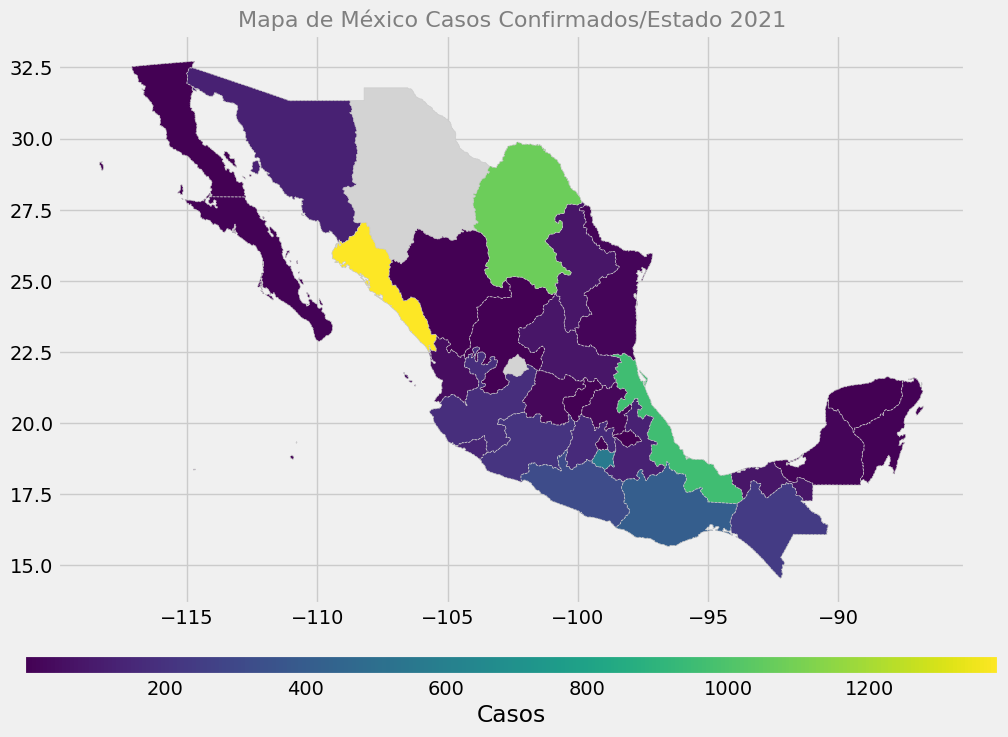

In [46]:
# Crear el mapa de cloropletas para los estados
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

gdf_estados.plot(ax=ax, 
                 color='lightgray', 
                 edgecolor='0.8')

merged_estados.plot(column='Casos', 
            cmap='viridis', 
            linewidth=0.5,
            linestyle='dashed', 
            ax=ax, 
            edgecolor='0.8',
            legend=True,
            legend_kwds={'label': "Casos", 'orientation': "horizontal", 'shrink': 0.7, 'pad': 0.07, 'aspect': 50})

# Agregar un título al mapa
plt.title('Mapa de México Casos Confirmados/Estado 2021',fontsize=16, color='#7f7f7f')

# Mostrar el mapa
plt.show()

In [47]:
fig1 = px.choropleth(data_frame=df_geo, 
                    geojson=gdf_estados, 
                    locations='Estado', # nombre de la columna del Dataframe
                    featureidkey='properties.name',  # ruta al campo del archivo GeoJSON con el que se hará la relación (nombre de los estados)
                    color='Casos',
                    color_continuous_scale="viridis"
                   )
fig1.update_geos(fitbounds="locations",
                showcountries=False, 
                showcoastlines=False, 
                #showland=True, landcolor="LightGreen",
                #showocean=True, oceancolor="LightBlue",
                )
fig1.update_layout(
    title_text = 'Mapa de México Casos Confirmados/Estado 2021',
    font=dict(
    size=18,
    color="#7f7f7f"
    ),
    title_x=0.5,
    width=1000,
    height=720
)
#fig1.show()

##### Casos confirmados por patología. Hombres Vs. Mujeres.

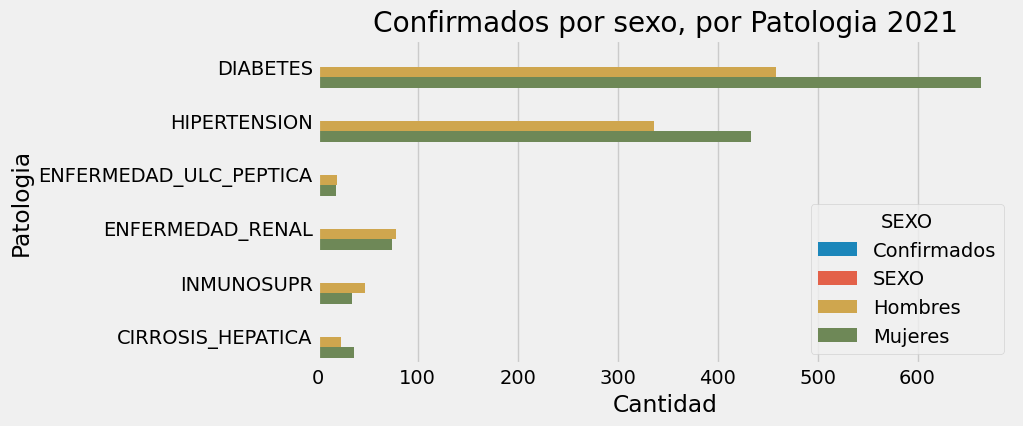

In [48]:
#Casos confirmados Hombres Vs. Mujeres. 
# Creemos un DataFrame nuevo con las columnas que necesitas
df_patologias = pd.DataFrame(columns=['Patologia', 'Confirmados', 'SEXO'])
patologias = ['DIABETES', 'HIPERTENSION', 'ENFERMEDAD_ULC_PEPTICA', 'ENFERMEDAD_RENAL', 'INMUNOSUPR', 'CIRROSIS_HEPATICA']

# Iteramos sobre las patologías
for patologia in patologias:
    # Contamos la cantidad cuando la patología es igual a 'SI' y el SEXO es 'Hombre'
    cantidad_hombre = df_dengue_2021[(df_dengue_2021[patologia] == 'SI') & (df_dengue_2021['SEXO'] == 'HOMBRE') ].shape[0]
    # Contamos la cantidad cuando la patología es igual a 'SI' y el SEXO es 'Mujer'
    cantidad_mujer = df_dengue_2021[(df_dengue_2021[patologia] == 'SI') & (df_dengue_2021['SEXO'] == 'MUJER')].shape[0]
    # Añadimos los resultados al nuevo DataFrame
    df_patologias = pd.concat([df_patologias, pd.DataFrame({'Patologia': [patologia], 'Hombres': [cantidad_hombre], 'Mujeres': [cantidad_mujer]})], ignore_index=True)

df_patologias.sort_values(by= 'Confirmados', ascending=False, inplace=True)

# Convertimos el DataFrame a formato largo
df_long = pd.melt(df_patologias, id_vars='Patologia', var_name='SEXO', value_name='Cantidad') 

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='Cantidad', y='Patologia', hue='SEXO', data=df_long)
ax.set(xlabel='Cantidad', ylabel='Patologia', title='Confirmados por sexo, por Patologia 2021')
plt.show()

##### Casos confirmados por patología. Grupos de edad. 

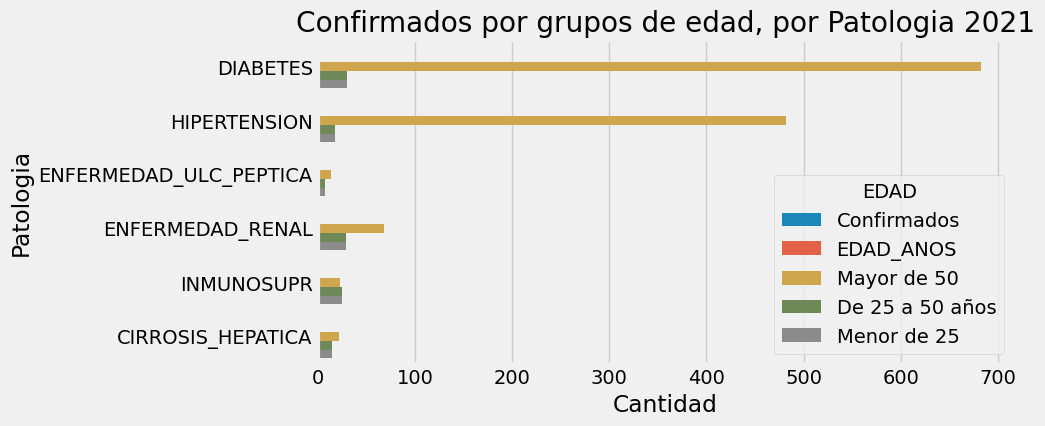

In [49]:
#Casos confirmados Hombres Vs. Mujeres. 
# Creemos un DataFrame nuevo con las columnas que necesitas
df_patologias = pd.DataFrame(columns=['Patologia', 'Confirmados', 'EDAD_ANOS'])
patologias = ['DIABETES', 'HIPERTENSION', 'ENFERMEDAD_ULC_PEPTICA', 'ENFERMEDAD_RENAL', 'INMUNOSUPR', 'CIRROSIS_HEPATICA']

# Iteramos sobre las patologías
for patologia in patologias:
    # Contamos la cantidad cuando la patología es igual a 'SI' y la edad es mayor de 50
    cantidad_mas40 = df_dengue_2021[(df_dengue_2021[patologia] == 'SI') & ((df_dengue_2021['EDAD_ANOS'] >50)) ].shape[0]
    #
    # Contamos la cantidad cuando la patología es igual a 'SI' y la edad entre 25 y 50
    cantidad_25a40 = df_dengue_2021[(df_dengue_2021[patologia] == 'SI') & ((df_dengue_2021['EDAD_ANOS'] <25 ) & (df_dengue_2021['EDAD_ANOS'] <50 ))].shape[0]
    # Contamos la cantidad cuando la patología es igual a 'SI' y la edad menor de 50

    cantidad_menos25 = df_dengue_2021[(df_dengue_2021[patologia] == 'SI') & ((df_dengue_2021['EDAD_ANOS'] <25)) ].shape[0]

    # Añadimos los resultados al nuevo DataFrame
    df_patologias = pd.concat([df_patologias, pd.DataFrame({'Patologia': [patologia], 'Mayor de 50': [cantidad_mas40], 'De 25 a 50 años': [cantidad_25a40], 'Menor de 25': [cantidad_menos25]})], ignore_index=True)

df_patologias.sort_values(by= 'Confirmados', ascending=False, inplace=True)

# Convertimos el DataFrame a formato largo
df_long = pd.melt(df_patologias, id_vars='Patologia', var_name='EDAD', value_name='Cantidad') 

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='Cantidad', y='Patologia', hue='EDAD', data=df_long)
ax.set(xlabel='Cantidad', ylabel='Patologia', title='Confirmados por grupos de edad, por Patologia 2021')
plt.show()

### Cerrando la conexión a la BD

In [50]:

connection.commit()

# Cierra la conexión con la base de datos.
connection.close()